In [1]:
from __future__ import division
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
file_name = 'tintina3le.txt'

with open(file_name, 'r') as data:
    entry = data.read()

entry_s = entry.splitlines()
nsats = len(entry_s)//3
    
sat_num = entry_s[1][2:7]  # satellite catalog number

epoch0 = float(entry_s[1][18:32])  # element set epoch (UTC)
n0d = float(entry_s[1][33:43])  # 1st derivative of mean motion w.r.t time
n0dd = float(entry_s[1][44:50])*10**float(entry_s[1][50:52])  # 2nd derivative of mean motion w.r.t. time
Bstar = float(entry_s[1][53:59])*10**float(entry_s[1][59:61])  # B* drag term
i0 = float(entry_s[2][8:16])  # orbit inclination (degrees)
phi0 = float(entry_s[2][17:25])  # right ascension of ascending node (degrees)
e0 = float(entry_s[2][26:33])  # eccentricity (decimal point assumed)
e0 = e0/10**(np.floor(np.log10(e0))+1)

w0 = float(entry_s[2][34:42])  # argument of perigee (degrees)
M0 = float(entry_s[2][43:51])  # mean anomaly (degrees)
n0 = float(entry_s[2][53:63])  # mean motion (revolutions/day)
rev0 = float(entry_s[2][63:68])  # revolution number at epoch

In [3]:
# create cosd and sind functions

def cosd(angle):
    """Calculates cosine in degrees"""
    return np.cos(np.deg2rad(angle))

def sind(angle):
    """Calculates sine in degrees"""
    return np.sin(np.deg2rad(angle))

def arctan2d(x,y):
    """Calculates arctan2 in degrees"""
    return np.rad2deg(np.arctan2(x,y))

## Nomenclature

$n_0 =$ the SGP type "mean" mean motion at epoch <br>
$e_0 =$ the "mean" eccentricity at epoch <br>
$i_0 =$ the "mean" inclination at epoch <br>
$k_e = \sqrt{GM}$ where G is Newton's universal gravitational constant and $M$ is the mass of the Earth <br>

In [4]:
# constants
CK2 = 5.413080e-4
CK4 = 0.62098875e-6
E6A = 1.0e-6
QOMS2T = 1.88027916e-9
S = 1.01222928
TOTHRD = .66666667
XJ3 = -0.253881e-5
XKE = 0.743669161e-1
XKMPER = 6378.135
XMNPDA = 1440
AE = 1.0
G = 6.67408e-11  # m3 kg-1 s-2
M = 5.972e24  # kg
RE = 6371  # km

In [5]:
# SGP4 Constants
a1 = (XKE/n0)**(2./3)

temp1 = 3./2*CK2*(3*cosd(i0)**2 - 1)/(1 - e0**2)**(3./2)
delta1 = temp1/a1**2
a0 = a1*(1 - 1./3*delta1 - delta1**2 - 134./81*delta1**3)
delta0 = temp1/a0**1
n0dd = n0/(1 + delta0)
a0dd = a0/(1 - delta0)

perigee = False
if 98 < perigee < 156:
    sstar = a0dd*(1 - e0) - S + AE
    QOMS2T = (QOMS2T**(1./4) + S - sstar)**4
elif perigee < 98:
    sstar = 20/XKMPER + AE
    QOMS2T = (QOMS2T**(1./4) + S - sstar)**4

theta = cosd(i0)
xi = 1./(a0dd - S)
Beta0 = (1 - e0**2)**(1./2)

eta = a0dd*e0*xi

C2 = QOMS2T*xi**4*n0dd*(1-eta**2)**(-7./2)* \
     (a0dd*(1 + 3./2*eta**2 + 4*e0*eta + e0 * eta**3) + \
     3./2*CK2*xi/(1-eta**2)*(-1./2 + 3./2*theta**2)*(8 + 24*eta**2 + 3*eta**4))
C1 = Bstar*C2

A3OVK2 = -XJ3/CK2*AE**3

C3 = QOMS2T*xi**5*A3OVK2*n0dd*AE*sind(i0)/e0
C4 = 2*n0dd*QOMS2T*xi**4*a0dd*Beta0**2*(1-eta**2)**(-7./2)*\
     ((2*eta*(1+e0*eta)+1./2*e0+1./2*eta**3)-\
     2*CK2*xi/(a0dd*(1-eta**2))*\
     (3*(1-3*theta**2)*(1+3./2*eta**2-2*e0*eta-1./2*e0*eta**3)+\
     3./4*(1-theta**2)*(2*eta**2-e0*eta-e0*eta**3)*cosd(2*w0)))
C5 = 2*QOMS2T*xi**4*a0dd*Beta0**2*(1-eta**2)**(-7./2)*(1+11./4*eta*(eta+e0)+e0*eta**3)

D2 = 4*a0dd*xi*C1**2
D3 = 4./3*a0dd*xi**2*(17*a0dd + S)*C1**3
D4 = 2./3*a0dd*xi**3*(221*a0dd + 31*S)*C1**4

In [6]:
def propagate(dt, threshold=0.001):
    """Perform SGP Propagation."""
    # The secular effects of atmospheric drag and gravitation are included
    # through the equations
    MDF = M0 + (1 + 3*CK2*(-1 + 3*theta**2)/(2*a0dd**2*Beta0**3) + \
               3*CK2**2*(13 - 78*theta**2 + 137*theta**4)/(16*a0dd**4*Beta0**7))*n0dd*dt


    wDF = w0 + (-3*CK2*(1 - 5*theta**2)/(2*a0dd**2*Beta0**4) + \
               3*CK2**2*(7 - 114*theta**2 + 395*theta**4)/(16*a0dd**4*Beta0**8) + \
               5*CK4*(3 - 36*theta**2 + 49*theta**4)/(4*a0dd**4*Beta0**8))*n0dd*dt


    phiDF = phi0 + (-3*CK2*theta/(a0dd**2*Beta0**4) + \
                    3*CK2**2*(4*theta - 19*theta**3)/(2*a0dd**4*Beta0**8) + \
                    5*CK4*theta*(3 - 7*theta**2)/(2*a0dd**4*Beta0**8))*n0dd*dt



    deltaw = Bstar*C3*cosd(w0)*dt
    deltaM = -2./3*QOMS2T*Bstar*xi**4*AE/(e0*eta)*((1 + eta*cosd(MDF))**3 - \
                                                   (1 + eta*cosd(M0))**3)
    MP = MDF + deltaw + deltaM
    w = wDF - deltaw - deltaM
    phi = phiDF - 21./2*(n0dd*CK2*theta)/(a0dd**2*Beta0**2)*C1*dt**2
    e = e0 - Bstar*C4*dt - Bstar*C5*(sind(MP)-sind(M0))

    a = a0dd*(1 - C1*dt - D2*dt**2 - D3*dt**3 - D4*dt**4)**2

    IL = MP + w + phi + n0dd*(3./2*C1*dt**2 + (D2 + 2*C1**2)*dt**3 + \
                              1./4*(3*D3 + 12*C1*D2 + 10*C1**3)*dt**4 + \
                              1./5*(3*D4 + 12*C1*D3 + 6*D2**2 + \
                                    30*C1**2*D2 + 15*C1**4)*dt**5)
    Beta = np.sqrt(1 - e**2)
    n = XKE/a**(3./2)
    
    # Add the long-period periodic terms
    axN = e*cosd(w)
    ILL = A3OVK2*sind(i0)/(8*a*Beta**2)*(e*cosd(w))*(3+5*theta)/(1+theta)
    ayNL = A3OVK2*sind(i0)/(4*a*Beta**2)
    ILT = IL + ILL
    ayN = e*sind(w) + ayNL

    # solve Kepler's equation for (E + w)
    U = ILT - phi

    newEw = U
    while True:
        Ew = newEw
        delEw = (U - ayN*cosd(Ew) + axN*sind(Ew) - Ew)/(-ayN*sind(Ew) - axN*cosd(Ew) + 1)
        newEw = Ew + delEw

        if abs(Ew - newEw) < threshold:
            break
            
    # some equations necessary for short-period periodics
    ecosE = axN*cosd(Ew) + ayN*sind(Ew)
    esinE = axN*sind(Ew) - ayN*cosd(Ew)

    eL = np.sqrt(axN**2 + ayN**2)
    pL = a*(1 - eL**2)
    r = a*(1 - ecosE)

    cosu = a/r*(cosd(Ew) - axN + ayN*esinE/(1 + np.sqrt(1 - eL**2)))
    sinu = a/r*(sind(Ew) - ayN - axN*esinE/(1 + np.sqrt(1 - eL**2)))

    u = arctan2d(sinu,cosu)
    
    deltar = CK2/(2*pL)*(1 - theta**2)*cosd(2*u)
    deltau = -CK2/(4*pL**2)*(7*theta**2 - 1)*sind(2*u)
    deltai = 3*CK2*theta/(2*pL**2)*sind(i0)*cosd(2*u)
    deltaphi = 3*CK2*theta/(2*pL**2)*sind(2*u)
    ik = i0 + deltai
    
    # update for short-periodics
    rk = r*(1 - 3./2*CK2*np.sqrt(1 - eL**2)/pL**2*(3*theta**2 - 1)) + deltar
    uk = u + deltau
    phik = phi + deltaphi
    
    # break out cartesian components
    Mx = -sind(phik)*cosd(ik)
    My = cosd(phik)*cosd(ik)
    Mz = sind(ik)

    Nx = cosd(phik)
    Ny = sind(phik)
    Nz = 0

    rx = rk*(Mx*sind(uk) + Nx*cosd(uk))
    ry = rk*(My*sind(uk) + Ny*cosd(uk))
    rz = rk*(Mz*sind(uk) + Nz*cosd(uk))
    
    return np.array([rx, ry, rz])

In [7]:
t = np.linspace(0,600,1000)

rx = np.zeros_like(t)
ry = np.zeros_like(t)
rz = np.zeros_like(t)
alt = np.zeros_like(t)

for idx, tsince in enumerate(t):
    temp = propagate(tsince)
    rx[idx] = temp[0]*RE
    ry[idx] = temp[1]*RE
    rz[idx] = temp[2]*RE
    alt[idx] = np.linalg.norm(temp)*RE

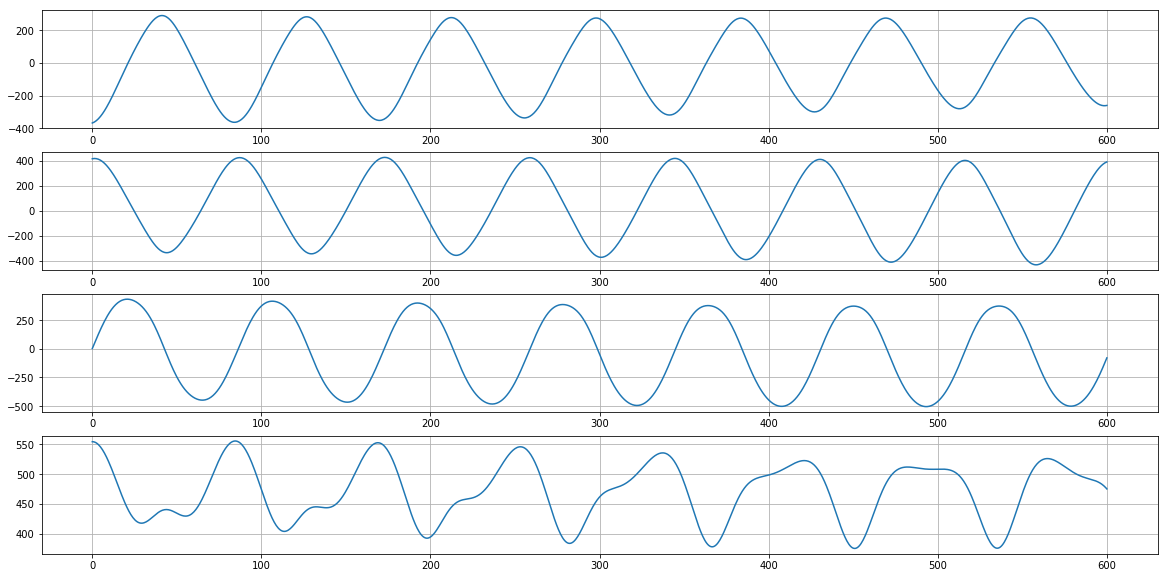

In [8]:
fix, ax = plt.subplots(4,1,figsize=(20,10))
ax[0].plot(t,rx)
ax[1].plot(t,ry)
ax[2].plot(t,rz)
ax[3].plot(t,alt)

for i in range(0,4):
    ax[i].grid()

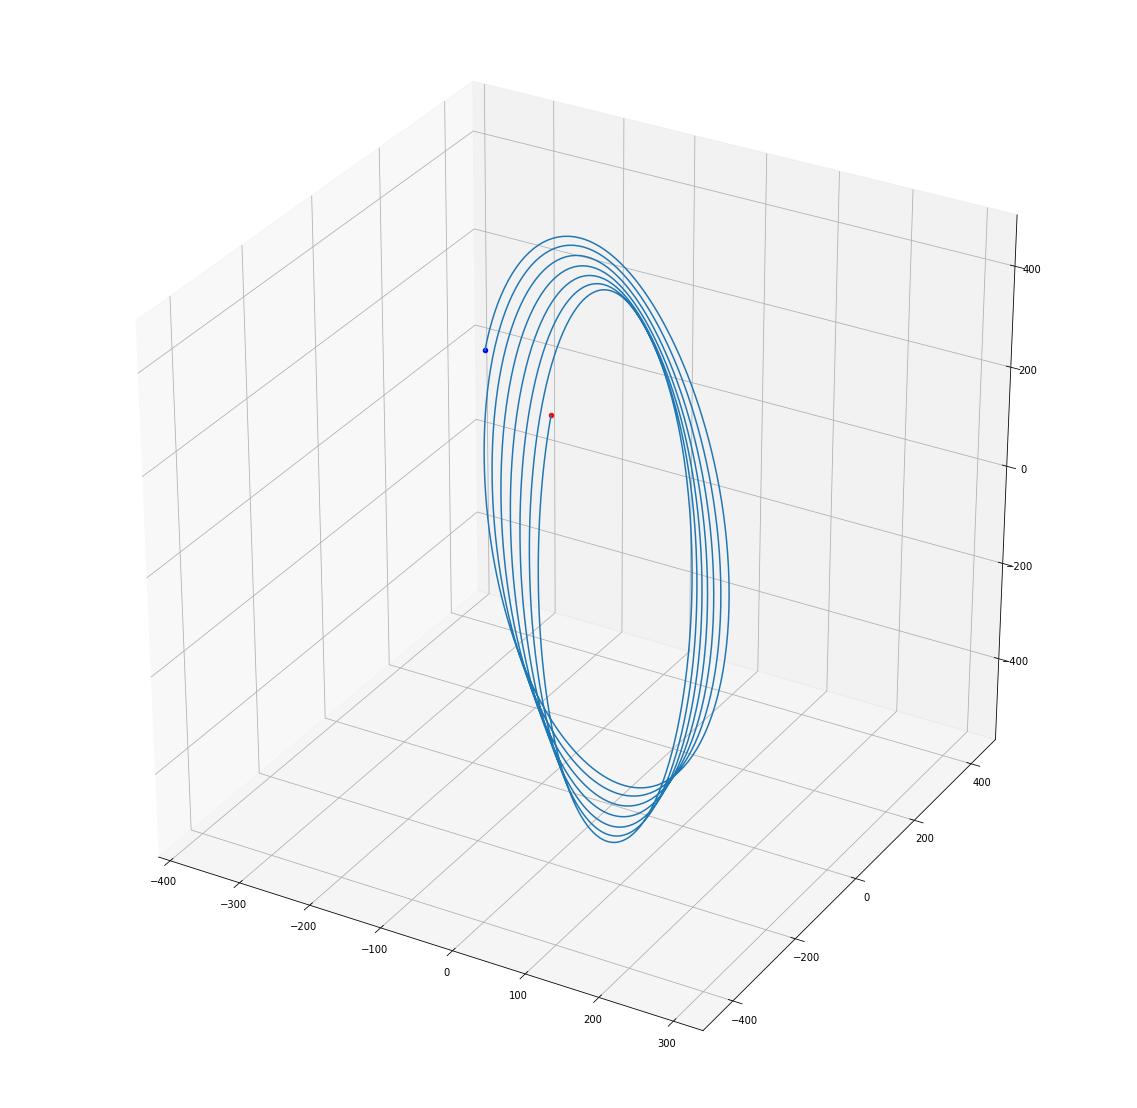

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rx,ry,rz, zorder=1)
ax.scatter(rx[0],ry[0],rz[0], color='b')
ax.scatter(rx[-1],ry[-1],rz[-1], color='r')
# ax.set_aspect('equal', 'box')